<a href="https://colab.research.google.com/github/BharathiDhereddy/Udacity-AI-ML-Project2/blob/main/Udacity_2nd_Image_Classifier(Use_Google_Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install git if it is not already installed
!apt-get install -q git

# Clone the repository created in the github account
!git clone https://github.com/BharathiDhereddy/udacity-image-classification.git

# Moving all files and folders to the /content folder
!mv udacity-image-classification/* /content/

# Optional: Removing the non-empty directory
!rm -r udacity-image-classification

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'udacity-image-classification'...
remote: Enumerating objects: 8526, done.
remote: Total 8526 (delta 0), reused 0 (delta 0), pack-reused 8526 (from 1)
Receiving objects: 100% (8526/8526), 330.32 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (8197/8197), done.


# Use Google Colab

Use T4 GPU

For it Click on the drop-down box - connect
then change runtime type
select T4 GPU
Saved**

In [2]:
# Import necessary packages for image classification

import time
from PIL import Image
import torch
from collections import OrderedDict
from torch import optim
from torch import nn
import torch.nn.functional as F
import json
from torchvision import datasets, models
from torchvision import  transforms as tfs

import numpy as np
import matplotlib.pyplot as plt


print("Necessary Libraries are  imported successfully.")

Necessary Libraries are  imported successfully.


In [3]:
# Defining the directories
dataset_dir = 'flowers'
training_dir = dataset_dir + '/train'
validation_dir = dataset_dir + '/valid'
testing_dir = dataset_dir + '/test'

# Define transformations for the training dataset
training_transforms = tfs.Compose([tfs.RandomRotation(30),
                                       tfs.RandomResizedCrop(224),
                                       tfs.RandomHorizontalFlip(),
                                       tfs.ToTensor(),
                                       tfs.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Define transformations for the validation dataset
validation_transforms = tfs.Compose([tfs.Resize(256),
                                       tfs.CenterCrop(224),
                                       tfs.ToTensor(),
                                       tfs.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Define transformations for the testing dataset
testing_transforms = tfs.Compose([tfs.Resize(256),
                                      tfs.CenterCrop(224),
                                      tfs.ToTensor(),
                                      tfs.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Loading dataset with ImageFolder
train_data = datasets.ImageFolder(training_dir, transform=training_transforms)
test_data = datasets.ImageFolder(testing_dir, transform=testing_transforms)
valid_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

# Defining the dataloaders for loading the dataset
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

print("Data has loaded successfully.")

Data has loaded successfully.


In [4]:
# Loading and mapping from Category Label to Category Name
with open('cat_to_name.json', 'r') as fs:
    cat_to_name = json.load(fs)

print("Category to name mapping loaded successfully.")

Category to name mapping loaded successfully.


In [5]:
# Loading a pre-trained vgg16 network
Model = models.vgg16_bn(pretrained=True)

# Freezing parameters so we don't backprop through them.
for params in Model.parameters():
    params.requires_grad = False

# Defining a new and untrained feed-forward network as a classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
Model.classifier = classifier

print("Model has been built successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 73.8MB/s]


Model has been built successfully.


In [7]:
# Set the device to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(Model.classifier.parameters(), lr=0.001)

epochs = 20
steps = 0
print_every = len(trainloader)  # This ensures the summary is printed once per epoch

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = Model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            Model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = Model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    valid_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader) * 100:.2f}%")
            running_loss = 0
            Model.train()

print("Training complete.")

Epoch 1/20.. Train loss: 0.983.. Validation loss: 0.406.. Validation accuracy: 89.09%
Epoch 2/20.. Train loss: 0.745.. Validation loss: 0.401.. Validation accuracy: 88.18%
Epoch 3/20.. Train loss: 0.662.. Validation loss: 0.365.. Validation accuracy: 90.56%
Epoch 4/20.. Train loss: 0.644.. Validation loss: 0.297.. Validation accuracy: 91.61%
Epoch 5/20.. Train loss: 0.571.. Validation loss: 0.339.. Validation accuracy: 91.52%
Epoch 6/20.. Train loss: 0.536.. Validation loss: 0.316.. Validation accuracy: 92.09%
Epoch 7/20.. Train loss: 0.543.. Validation loss: 0.237.. Validation accuracy: 94.62%
Epoch 8/20.. Train loss: 0.520.. Validation loss: 0.273.. Validation accuracy: 93.80%
Epoch 9/20.. Train loss: 0.513.. Validation loss: 0.321.. Validation accuracy: 92.57%
Epoch 10/20.. Train loss: 0.525.. Validation loss: 0.290.. Validation accuracy: 93.18%
Epoch 11/20.. Train loss: 0.494.. Validation loss: 0.269.. Validation accuracy: 94.50%
Epoch 12/20.. Train loss: 0.508.. Validation loss: 0

In [8]:
# Test the network
test_loss = 0
accuracy = 0
Model.eval()
with torch.no_grad():
    # Assuming 'testloader' is the name of your test dataloader
    for inputs, labels in testloader:  # Replace 'dataloaders['test']' with 'testloader'
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        logps = Model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Loss: {test_loss/len(testloader):.3f}.. "  # Also replace here
      f"Test Accuracy: {accuracy/len(testloader):.3f}")  # And here

Test Loss: 0.317.. Test Accuracy: 0.926


In [9]:
# Save the checkpoint
# Assuming 'train_data' is the ImageFolder dataset used for training:
Model.class_to_idx = train_data.class_to_idx  # Replace 'train_dataset' with the correct variable

checkpoint = {
    'state_dict': Model.state_dict(),
    'class_to_idx': Model.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

In [10]:
# Load the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    Model = models.vgg16(pretrained=True)

    for params in Model.parameters():
        params.requires_grad = False

    Model.classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout(0.5)),
        ('fc2', nn.Linear(4096, 102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    Model.load_state_dict(checkpoint['state_dict'])
    Model.class_to_idx = checkpoint['class_to_idx']

    return Model

In [11]:
def process_image(image_path):
    pil_image = Image.open(image_path)
    pil_image = pil_image.resize((256, 256))
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = (pil_image.width + 224) / 2
    bottom = (pil_image.height + 224) / 2
    pil_image = pil_image.crop((left, top, right, bottom))
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    np_image = np_image.transpose((2, 0, 1))
    return torch.tensor(np_image).float()

def predict(image_path, Model, topk=5):
    image = process_image(image_path)
    image = image.unsqueeze(0)
    Model.eval()
    # Move the image to the same device as the model
    image = image.to(device)  # Add this line
    with torch.no_grad():
        outputs = Model(image)
        ps = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(topk, dim=1)
        idx_to_class = {v: k for k, v in Model.class_to_idx.items()}
        top_class = top_class.cpu().numpy()[0]
        top_class = [idx_to_class[i] for i in top_class]
    return top_p.cpu().numpy()[0], top_class

print("Inference function for classification is ready.")



Inference function for classification is ready.


In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    return ax

import seaborn as sns
def plot_solution(image_path, Model):
    plt.figure(figsize=(6,10))
    ax = plt.subplot(2,1,1)
    img = process_image(image_path)
    # Assuming 'cat_to_name' maps class indices to flower names
    flower_class = image_path.split('/')[-2]  # Extract the class from the path
    title = cat_to_name.get(flower_class, 'Unknown Flower')  # Handle potential missing keys
    imshow(img, ax, title=title)
    probs, classes = predict(image_path, Model)
    class_names = [cat_to_name.get(item, 'Unknown Flower') for item in classes]  # Handle potential missing keys
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=class_names, color=sns.color_palette()[0])
    plt.show()

print("Prediction display function is ready.")


Prediction display function is ready.


Model is loaded on the device: cuda
Image processed successfully.
Predicted probabilities:  [9.9999881e-01 1.2312657e-06 3.9173301e-08 5.8060207e-10 4.6524898e-10]
Predicted classes:  ['1', '51', '83', '45', '70']


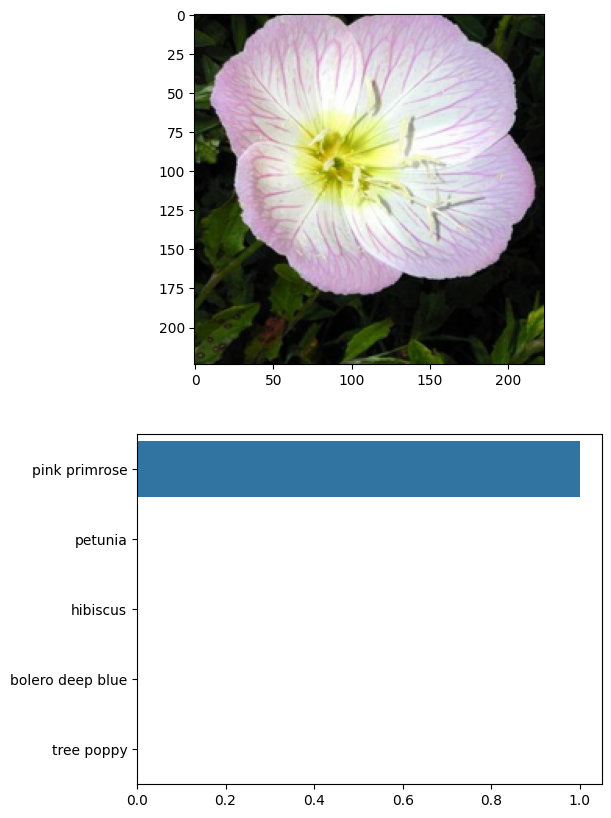

Prediction display completed successfully.


In [13]:
# Load the model and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model.to(device)
print("Model is loaded on the device:", device)

# Process and predict
image_path = '/content/flowers/test/1/image_06743.jpg'
img = process_image(image_path)
print("Image processed successfully.")

probs, classes = predict(image_path, Model)
print("Predicted probabilities: ", probs)
print("Predicted classes: ", classes)

# Display the result
plot_solution(image_path, Model)
print("Prediction display completed successfully.")